In [115]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.affinity import scale, translate
from tqdm.notebook import tqdm_notebook

os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()

In [116]:
import cv2

In [175]:
GEOJSON_PATH = './data/GeoJson/H21-066.4_HE332_033_Scan1.qptiff - resolution #1.geojson'
GEOJSON_PATH_2 = './data/GeoJson/H21-066.4_HE332_225_Scan1#1.geojson'
IMAGE_PATH = './data/66-4/H21-066.4_HE332_033/processed_4/H21-066.4_HE332_033_Scan1.tif'
LABEL_DICT = {'epithelium':1, 'blood_vessels':2, 'stroma':3, 'adipocytes':4}
COLOR_DICT = {'epithelium':np.array([255, 0, 0]), 'blood_vessels':np.array([0, 0, 255]), 'stroma':np.array([0, 255, 0]) , 'adipocytes':np.array([255, 255, 0])}

In [193]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        #print(f"Folder '{folder_path}' created successfully.")
    else:
        pass
        #print(f"Folder '{folder_path}' already exists.")

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)


def get_color(path):
    if "epithelium" in path:
        return COLOR_DICT["epithelium"]
    elif "blood_vessels" in path:
        return COLOR_DICT["blood_vessels"]
    elif "stroma" in path:
        return COLOR_DICT["stroma"]
    else:
        return COLOR_DICT["adipocytes"]
    
def get_label_index(path):
    if "epithelium" in path:
        return LABEL_DICT["epithelium"]
    elif "blood_vessels" in path:
        return LABEL_DICT["blood_vessels"]
    elif "stroma" in path:
        return LABEL_DICT["stroma"]
    else:
        return LABEL_DICT["adipocytes"]

def get_largest_polygon(gdf):
    largest_polygon = None
    largest_area = -1
    i = 0

    for index, row in gdf.iterrows():
        polygon = row['geometry']
        area = polygon.area
        if area > largest_area:
            largest_area = area
            largest_polygon = polygon
            i = index
    
    print("The larges polygon is in the row: ", i)
    return largest_polygon

def scale_geometry(geom, scaling_factor):
    return scale(geom, xfact=scaling_factor, yfact=scaling_factor, zfact=1, origin=(0, 0))

def load_labels(path, downscaling_factor=None):
    to_drop = ["id", "objectType", "classification", "object_type", "isLocked"]
    labels_df = gpd.read_file(path)
    names = list(labels_df["classification"][0].keys())
    labels_df["label"] = labels_df["classification"].apply(lambda x: x[names[0]])
    #labels_df["color"] = labels_df["classification"].apply(lambda x: rgb_to_hex(x[encoded_names[1]]))
    labels_df = labels_df.drop(columns=to_drop, errors="ignore")
    # Scale the coordinates
    if downscaling_factor is not None:
        labels_df['geometry'] = labels_df['geometry'].apply(lambda row: scale_geometry(row, (1/downscaling_factor)))

    # Encode and clean labels based in dict
    labels_df["label"] = labels_df["label"].str.lower()
    labels_df["label"] = labels_df["label"].str.replace(" ", "_")
    # Fix because labels are not consistent in the data
    labels_df['label'] = labels_df['label'].apply(lambda x: 'blood_vessels' if 'blood_vessel' in x else x)
    labels_df['label'] = labels_df['label'].apply(lambda x: 'adipocytes' if 'fat' in x else x)

    labels_df["encoded_label"] = labels_df["label"].apply(lambda x: LABEL_DICT[x])

    return labels_df

def load_image(img_path):
    image = cv2.imread(img_path)
    return image

def get_tif_paths(path, resolution):
    path_list = []
    for paths in os.walk(path, topdown=False):
        root = paths[0]
        if "processed_"+str(resolution) in root:
            for file in paths[-1]:
                path_list.append(os.path.join(root, file))
    return path_list
    
def get_labelled_files(labels_path, file_list):
    # Returns a tuple with image and labels associated with it
    file_label_list = []
    if len(file_list) == 0:
        raise("Create preprocessed files for this resolution")
    
    labelled_files = os.listdir(labels_path)
    for file in file_list:
        file_name = os.path.splitext(os.path.basename(file))[0]
        for labelled_file in labelled_files:
            if file_name in labelled_file:
                file_label_list.append((file, os.path.join(labels_path, labelled_file)))

    return file_label_list


def extract_label(image, image_name, training_storage, encoded_label, label, geometry, idx):#labels_df, idx):
    folder_name = str(encoded_label) + "_" + (label)
    polygon_gdf = geometry
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = np.floor(polygon_gdf.bounds).astype("int64")
    crop = image[min_y:max_y, min_x:max_x]

    translate_x = ((max_x-min_x) - polygon_gdf.bounds[0] - polygon_gdf.bounds[2]) / 2
    translate_y = ((max_y-min_y) - polygon_gdf.bounds[1] - polygon_gdf.bounds[3]) / 2
    translated_polygon = translate(polygon_gdf, xoff=translate_x, yoff=translate_y)

    contour = np.array([[int(x), int(y)] for x, y in translated_polygon.exterior.coords])

    mask = np.zeros_like(crop)*255
    cv2.fillPoly(mask, pts=[contour], color=(255,255,255))
    masked_img = cv2.bitwise_and(crop, mask)

    cv2.imwrite(os.path.join(training_storage, folder_name, image_name + "_" + label+"_"+str(idx)+".png"), masked_img)
    
    return True

def check_fill(masked_img, matrix_size):
    return sum(sum(np.where(masked_img>0, 1, 0)))/(matrix_size**2)

In [132]:
test_df = load_labels(GEOJSON_PATH, downscaling_factor=32)

In [133]:
test_df["geometry"][0].area

47.3355997558594

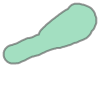

In [134]:
test_df["geometry"][0]

In [176]:
def generate_training_labels(images_path, labels_path, resolution):
    training_storage = "./data/processed_labels_"+str(resolution)
    create_folder(training_storage)
    [create_folder(os.path.join(training_storage,str(LABEL_DICT[key])+"_"+key)) for key in LABEL_DICT]

    files_list = get_tif_paths(images_path, resolution)
    file_label_list = get_labelled_files(labels_path, files_list)
    for img_path, label_path in file_label_list:
        image_name = os.path.splitext(os.path.basename(img_path))[0]
        print("Extracting image ", image_name, "labels...")
        image = load_image(img_path)
        labels_df  = load_labels(label_path, int(resolution))
        
        
        # Apply function to extract label for each row
        for idx, row in tqdm_notebook(labels_df.iterrows()):
            extract_label(image, image_name, training_storage, row["encoded_label"], row["label"], row["geometry"], idx)

generate_training_labels("./data/66-4", "./data/GeoJson", 32)

Extracting image  H21-066.4_HE332_033_Scan1 labels...


0it [00:00, ?it/s]

Extracting image  H21-066.4_HE332_089_Scan1 labels...


0it [00:00, ?it/s]

Extracting image  H21-066.4_HE332_105_Scan1 labels...


0it [00:00, ?it/s]

Extracting image  H21-066.4_HE332_137_Scan1 labels...


0it [00:00, ?it/s]

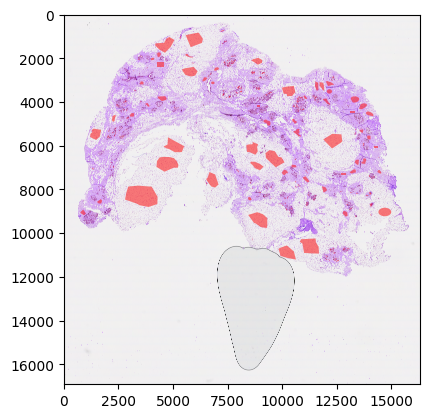

In [6]:
# Load the TIFF image
resolution = "4"
image = load_image('./data/66-4/H21-066.4_HE332_033/processed_'+resolution+'/H21-066.4_HE332_033_Scan1.tif')
labels_df  = load_labels('./data/GeoJson/H21-066.4_HE332_033_Scan1.qptiff - resolution #1.geojson', int(resolution))
labels_df.plot(ax=plt.gca(), color='red', alpha=0.5, aspect=1)
plt.imshow(image)
plt.show()

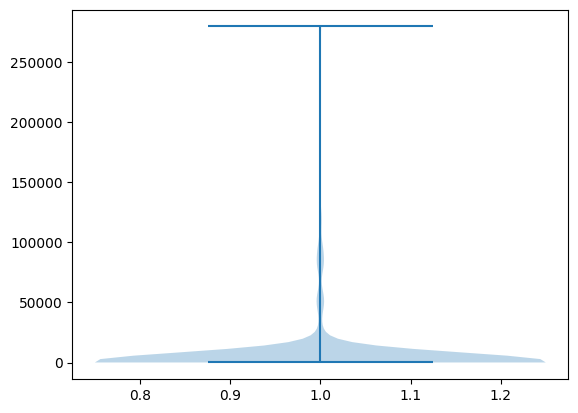

In [79]:
resolution = "8"
image = load_image('./data/66-4/H21-066.4_HE332_033/processed_'+resolution+'/H21-066.4_HE332_033_Scan1.tif')
labels_df  = load_labels('./data/GeoJson/H21-066.4_HE332_033_Scan1.qptiff - resolution #1.geojson', int(resolution))

areas_list = []
for index, row in labels_df.iterrows():
        polygon = row['geometry']
        area = polygon.area
        areas_list.append(area)

plt.violinplot(areas_list)
plt.show()

In [88]:
print(np.array(areas_list).min())
print(np.array(areas_list).mean())
print(np.array(areas_list).max())

30.0234375
6027.467757288461
279719.71875


Big image resolution Comparison

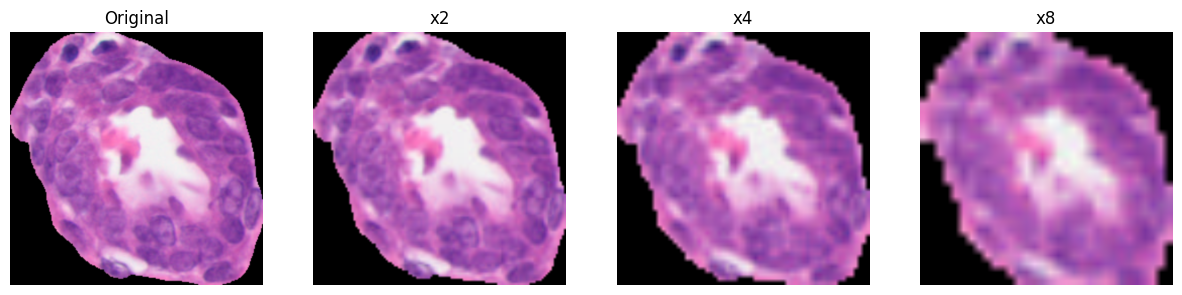

In [70]:
# Initialize an empty list to store images
images = []

# Loop through files in the directory
for file in os.listdir():
    if "smallSeg" in file:
        image = cv2.imread(file)
        # Resize the image to a common size (e.g., 200x200)
        resized_image = cv2.resize(image, (1000, 1000))  # Adjust dimensions as needed
        # Append the resized image to the list
        images.append(resized_image)

# Concatenate the images horizontally
concatenated_images = cv2.hconcat(images)

plt.figure(figsize=(15, 5)) 
# Show each image with a title
list = ["Original", "x2", "x4", "x8"]

for i, image in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(list[i])  # Add a title to the image
    plt.axis('off')
# Show the concatenated image
plt.show()


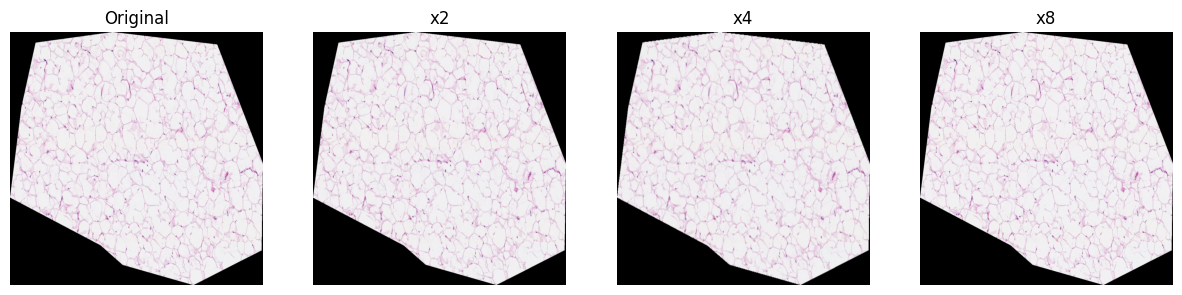

In [71]:
# Initialize an empty list to store images
images = []

# Loop through files in the directory
for file in os.listdir():
    if "bigSeg" in file:
        image = cv2.imread(file)
        # Resize the image to a common size (e.g., 200x200)
        resized_image = cv2.resize(image, (1000, 1000))  # Adjust dimensions as needed
        # Append the resized image to the list
        images.append(resized_image)

# Concatenate the images horizontally
concatenated_images = cv2.hconcat(images)

plt.figure(figsize=(15, 5)) 
# Show each image with a title
list = ["Original", "x2", "x4", "x8"]

for i, image in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(list[i])  # Add a title to the image
    plt.axis('off')
# Show the concatenated image
plt.show()

# Training Pipeline

## Preprocessing

### Normalize training images

Can be done later

### Optical Density?
Can be done later

### Bounding boxes of annotations

In [58]:
resolution = "4"
image = load_image('./data/66-4/H21-066.4_HE332_033/processed_'+resolution+'/H21-066.4_HE332_033_Scan1.tif')
labels_df  = load_labels('./data/GeoJson/H21-066.4_HE332_033_Scan1.qptiff - resolution #1.geojson', int(resolution))

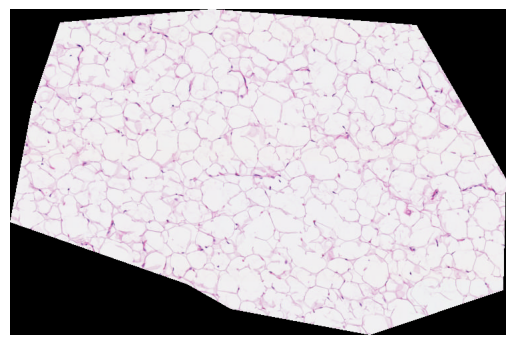

True

In [29]:
extract_label(image, labels_df, 316)

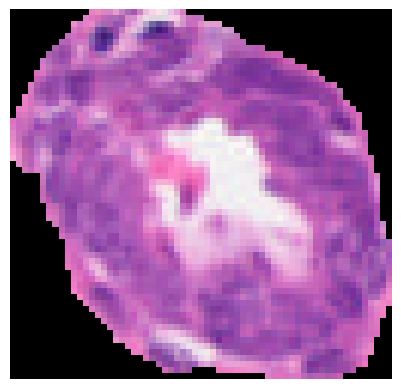

True

In [60]:
extract_label(image, labels_df, 37)

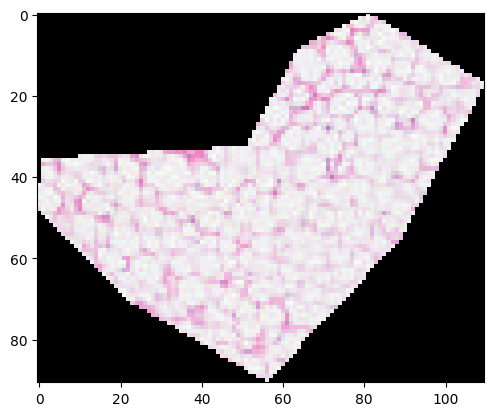

In [142]:
test_path = "./data/processed_labels_32/3_adipocytes/H21-066.4_HE332_033_Scan1_adipocytes_312.png"
image = cv2.imread(test_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

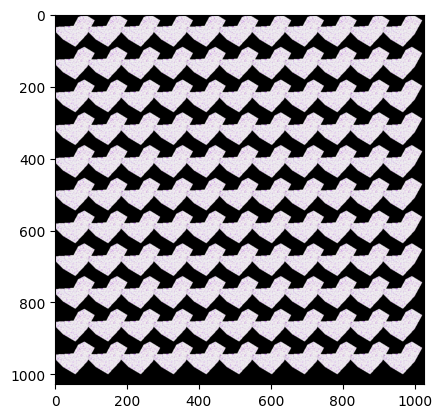

In [143]:
matrix_size = 1028
global_draft = np.zeros((matrix_size, matrix_size, 3), dtype=np.uint8)
rgb_image = cv2.imread(test_path)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Threshold the grayscale image to get a binary mask of non-black pixels
_, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
# Convert the binary mask to a matrix with labels
labels_matrix = np.where(mask > 0, 1, 0)

x_mark, y_mark = 0, 0
for i, x in enumerate(range(5000)):
    # Grow horizontally
    if x_mark+labels_matrix.shape[0] < global_draft.shape[0]:
        if y_mark+labels_matrix.shape[1] > global_draft.shape[1]:
            break
        global_draft[x_mark:x_mark+labels_matrix.shape[0],y_mark:y_mark+labels_matrix.shape[1]] += rgb_image
        x_mark += labels_matrix.shape[0]
    else:
        x_mark = 0
        y_mark += labels_matrix.shape[0]

plt.imshow(global_draft)


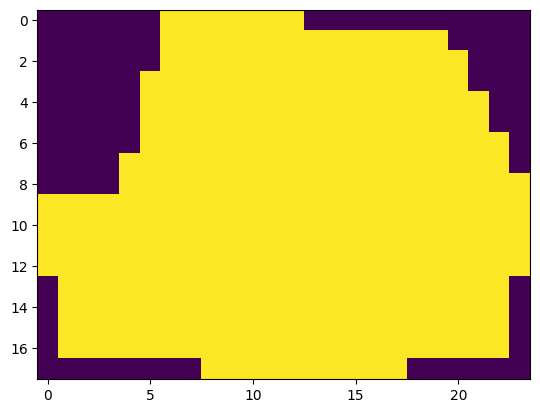

In [136]:
# Convert the color image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Threshold the grayscale image to get a binary mask of non-black pixels
_, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
# Convert the binary mask to a matrix with labels
labels_matrix = np.where(mask > 0, 1, 0)
# Print the labels matrix
plt.imshow(labels_matrix)

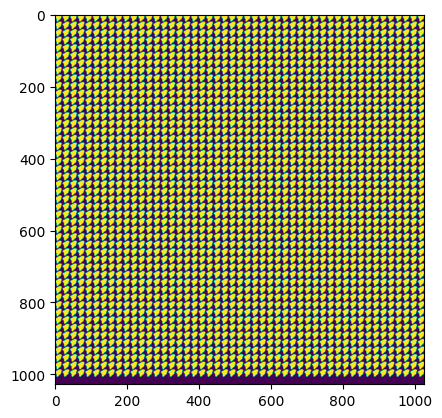

In [10]:
# Fill with same number of labels
global_image = np.zeros((1028, 1028))
x_mark, y_mark = 0, 0
for i, x in enumerate(range(3000)):
    # Grow horizontally
    if x_mark+labels_matrix.shape[0] < global_image.shape[0]:
        if y_mark+labels_matrix.shape[1] > global_image.shape[1]:
            break
        global_image[x_mark:x_mark+labels_matrix.shape[0],y_mark:y_mark+labels_matrix.shape[1]] += labels_matrix
        x_mark += labels_matrix.shape[0]
    else:
        x_mark = 0
        y_mark += labels_matrix.shape[0]

plt.imshow(global_image)

In [178]:
import os

# Define the directory containing your images
directory = './data/processed_labels_32'

# Create a list to store image file paths
image_files = []

# Recursively traverse through the directory and subdirectories
for root, dirs, files in os.walk(directory):
    # Filter files with image extensions
    for file in files:
        if file.lower().endswith(('.png')):
            # Construct the full path of the image file
            image_path = os.path.join(root, file)
            # Append the image file path to the list
            image_files.append(image_path)


In [171]:
image_files[0]


In [172]:
get_color(image_files[0])

array([255,   0,   0])

In [181]:
mask_list = []
rgb_list = []
for f in tqdm_notebook(image_files):
    
    image = cv2.imread(f)
    rgb_list.append(image)

    # Convert the color image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the grayscale image to get a binary mask of non-black pixels
    _, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    # Convert the binary mask to a matrix with labels
    labels_matrix = np.where(mask > 0, get_label_index(f), 0)
    mask_list.append(labels_matrix)

  0%|          | 0/949 [00:00<?, ?it/s]

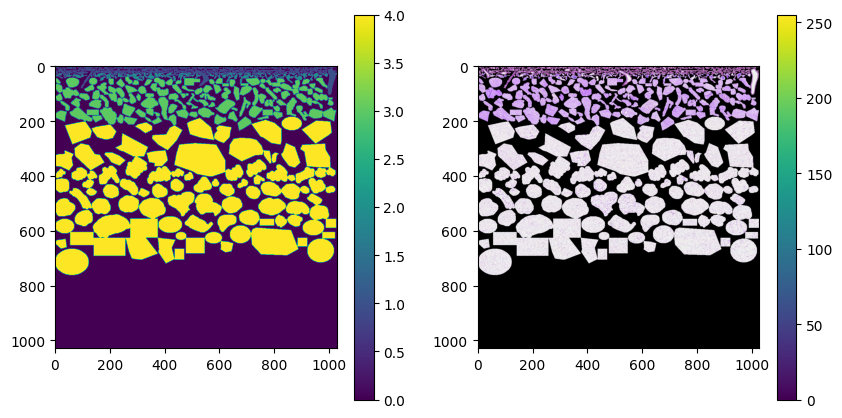

In [183]:
# Initialize the global image matrix
matrix_size = 1028
global_image = np.zeros((matrix_size, matrix_size))
global_rgb = np.zeros((matrix_size, matrix_size, 3), dtype=np.uint8)


check = 0
x_mark, y_mark = 0, 0

# Iterate over each mask
for i, labels_matrix in enumerate(mask_list):
    #print(i)
    #x_mark, y_mark = 0, 0
    if check == 1:
        break
    
    # Iterate over rows of the global image
    while x_mark + labels_matrix.shape[0] < global_image.shape[0]:
        # Check if the mask fits horizontally without going out of bounds
        if y_mark + labels_matrix.shape[1] > global_image.shape[1]:
            # Move to the next row
            x_mark += 1
            y_mark = 0
            if x_mark == 1028 and y_mark == 1028:
                check = 1
                break
            continue
        
        # Check if the current position in the global image is empty
        if np.all(global_image[x_mark:x_mark+labels_matrix.shape[0], y_mark:y_mark+labels_matrix.shape[1]] == 0):
            # Place the mask into the global image
            global_image[x_mark:x_mark+labels_matrix.shape[0], y_mark:y_mark+labels_matrix.shape[1]] += labels_matrix
            global_rgb[x_mark:x_mark+labels_matrix.shape[0], y_mark:y_mark+labels_matrix.shape[1]] += rgb_list[i]
            break
        
        # Move to the next column
        y_mark += 1
    

# Display the global image
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image and its colorbar
im1 = axes[0].imshow(global_image, cmap='viridis')
fig.colorbar(im1, ax=axes[0])

# Plot the second image and its colorbar
im2 = axes[1].imshow(global_rgb, cmap='viridis')
fig.colorbar(im2, ax=axes[1])
plt.show()

In [197]:
check_fill(global_image, 1028)

0.4167237581189723

In [200]:
unique_values, counts = np.unique(global_image, return_counts=True)

# Create a dictionary to store the counts for each value
count_dict = dict(zip(unique_values, counts))

print("Count of pixels for each integer value:")
print(count_dict)

Count of pixels for each integer value:
{0.0: 616397, 1.0: 21894, 2.0: 9387, 3.0: 87064, 4.0: 322042}


### Save each region as a separated image file

### Matrix to keep track of annotations tissue type (label)

## Training

### Create a 9000x9000x3 grid

### Fill the grid with bounding boxes until >65% of area is filled 

- Keep track o equal n pixel per class.
- Randomly augment bounding boxes by using rotation, scaling, hue


### Crop 9000x9000 images into 500x500 (324 image per 9000 tile)

In CODA they use 20 images of 9Kx9K for training, 5 of 9Kx9k for validation and 1 unlabelled for testing.

This results in:
- Train: 6480
- Validation: 1620
- Test 324

## Evaluation 

They looked for >90% precision and recall accuracies for every tissue type